# クラス分類学習モデルの作成、予測の実行

In [38]:
import os
import random

# basic DS libraries
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# plot libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from seaborn_analyzer import classplot
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO

%matplotlib inline

# プログレスバー
from tqdm import tqdm

# 機械学習モデル
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析

# データセット分割・評価検証
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# config python file
import config

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

# ファイル保存関数（dirがなければ生成する）
def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


# seedの固定
def fix_seed(seed: int):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)


# 再現性をもたせるためのseed固定
SEED = config.SEED
fix_seed(SEED)

In [39]:
def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


# 特徴量チェック
def check(df):
    col_list = df.columns.values  # 列名を取得
    row = []
    for col in col_list:
        unique = ""
        value_counts = ""
        if df[col].nunique() < 12:
            unique = df[col].unique()
            value_counts = df[col].value_counts().to_dict()
        tmp = (
            col,  # 列名
            df[col].dtypes,  # データタイプ
            df[col].isnull().sum(),  # null数
            df[col].count(),  # データ数 (欠損値除く)
            df[col].nunique(),  # ユニーク値の数 (欠損値除く)
            unique,  # ユニーク値
            value_counts,  # ユニーク値のそれぞれの個数
        )
        row.append(tmp)  # tmpを順次rowに保存
    df = pd.DataFrame(row)  # rowをデータフレームの形式に変換
    df.columns = [
        "feature",
        "dtypes",
        "nan",
        "count",
        "num_unique",
        "unique",
        "unique_counts",
    ]  # データフレームの列名指定
    # unique_countsの中身確認のために横幅拡張
    d = dict(selector=".col8", props=[("min-width", "200px")])  # name
    # display(df.style.set_table_styles([d]))
    # display(df)
    return df.style.set_table_styles([d])

# 2値分類モデルの作成・実行

2値分類モデルを作成、実行し、クラス分類に有用な特徴量を見つける  
決定木以外にも、基本的な2値分類を実施できるモデルを採用し、各モデル間で比較していく。  
精度は重視しないが、accuracyよりもf1スコアを重視する。  
目的変数に偏りがある（不均衡データ、1（5年後以内に死亡）<0（5年語以内に生存））ので、**サンプリング方法を要検討**

In [40]:
df_MB_encoded = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_DIR + "/df_MB_encoded.pkl"
)
check(df_MB_encoded)

,feature,dtypes,nan,count,num_unique,unique,unique_counts
0,LYMPH_NODES_EXAMINED_POSITIVE,float64,0,1251,27,,
1,NPI,float64,0,1251,208,,
2,CELLULARITY,int64,0,1251,3,[3 2 1],"{3: 615, 2: 500, 1: 136}"
3,CHEMOTHERAPY,int64,0,1251,2,[0 1],"{0: 972, 1: 279}"
4,INFERRED_MENOPAUSAL_STATE,int64,0,1251,2,[0 1],"{1: 952, 0: 299}"
5,AGE_AT_DIAGNOSIS,float64,0,1251,1089,,
6,GRADE,float64,0,1251,3,[3. 2. 1.],"{3.0: 665, 2.0: 492, 1.0: 94}"
7,PR_STATUS,int64,0,1251,2,[1 0],"{1: 659, 0: 592}"
8,TMB_NONSYNONYMOUS,float64,0,1251,29,,
9,ER_IHC,int64,0,1251,2,[1 0],"{1: 969, 0: 282}"


In [41]:
print(
    "データセット全体に占める5年後の死亡者のデータの割合： ",
    df_MB_encoded[df_MB_encoded.target_OS_5years == True].shape[0]
    / df_MB_encoded.shape[0],
)

データセット全体に占める5年後の死亡者のデータの割合：  0.18784972022382093


# 学習データ分割

1. X（説明変数）とy（目的変数）に分割(y=df['target'])
2. train_test_splitによる基本的なデータ分割（train:test=75%:25%）※層化検証など他の分割手法は後で実施  

In [42]:
# Xとyに分割
X = df_MB_encoded.drop("target_OS_5years", axis=1)
y = df_MB_encoded["target_OS_5years"].astype(bool)

In [43]:
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.SEED)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
display(y_train.value_counts(), y_test.value_counts())

(938, 53)

(313, 53)

(938,)

(313,)

False    765
True     173
Name: target_OS_5years, dtype: int64

False    251
True      62
Name: target_OS_5years, dtype: int64

# 2値分類モデル

In [44]:
def show_scores(y_test: pd.Series, y_pred_tree: pd.Series):
    print("accuracy: ", accuracy_score(y_test, y_pred_tree))
    print("precision: ", precision_score(y_test, y_pred_tree))
    print("recall: ", recall_score(y_test, y_pred_tree))
    print("f1 score: ", f1_score(y_test, y_pred_tree))

In [45]:
def show_confusion_matrix(
    y_test: pd.Series,
    y_pred: pd.Series,
    model_name: str = "confusion matrix",
    display_details: bool = False,
):
    cm = confusion_matrix(y_test, y_pred, normalize="all", labels=[True, False])
    df_cm = pd.DataFrame(data=cm, index=[True, False], columns=[True, False])

    fig = plt.figure()
    sns.heatmap(df_cm, square=True, cbar=True, annot=True, cmap="Blues")
    plt.title(model_name)
    plt.xlabel("Predict label")
    plt.ylabel("True label")
    plt.plot()

    if display_details:
        tn, fp, fn, tp = cm.ravel()
        print("tn: ", tn, "\nfp: ", fp, "\nfn:", fn, "\ntp:", tp)
        show_scores(y_test, y_pred)

## ベースラインの精度

全てFalseと予測（学習データはFalseが多いため）した場合のスコア

False    251
True      62
Name: target_OS_5years, dtype: int64

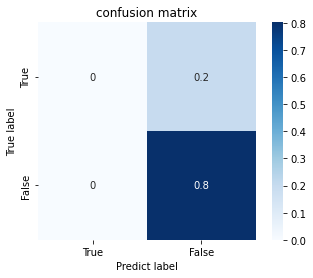

In [46]:
y_base = pd.Series([False for i in range(y_test.shape[0])], index=y_test.index)
display(y_test.value_counts())
show_confusion_matrix(y_test, y_base)

# 様々な機械学習手法の比較

様々な機械学習手法を用いて2値分類を行う。  
簡単に精度を見るため、再現性は担保されていない（引数にrandom_stateを要求しないclfもあるため）ので、必要に応じて再度モデルを構築すること。  
また、パラメータはデフォルト値を使用している。  
そのためパラメータ次第では結果が向上、下降しうる（決定木のf1など）。  

In [47]:
bcm_names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "Polynomial SVM",
    "RBF SVM",
    "Sigmoid SVM",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    # "Linear Discriminant Analysis", # predictメソッドに対応していない
    "Quadratic Discriminant Analysis",
]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(kernel="poly"),
    SVC(kernel="rbf"),
    SVC(kernel="sigmoid"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    # LDA(),
    QDA(),
]

In [48]:
import warnings


def compare_bcms(
    X: pd.DataFrame(),
    y: pd.Series(),
    bcm_names: list = bcm_names,
    classifiers: list = classifiers,
    sort_column_name: str = "f1_test",
    average_time: int = 20,
    test_size: float = 0.25,
    over_sampling=None,
    plot_columns: list = ["AGE_AT_DIAGNOSIS", "TMB_NONSYNONYMOUS"],
):
    warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示
    result = []

    for name, clf in zip(bcm_names, classifiers):  # 指定した複数の分類機を順番に呼び出す
        # 乱数の影響を均した平均を取りたいので、SEEDは保留。乱数に依存しない精度を見るので再現性は'ここでは'担保しない。
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size
        )  # 訓練データ・テストデータの生成
        if over_sampling:
            X_train, y_train = sm.fit_resample(X_train, y_train)
        for _ in tqdm(range(average_time)):  # average_time 回繰り返し、指標の平均を見る
            # 訓練のスコア
            clf.fit(X_train, y_train)  # 学習
            y_pred_train = clf.predict(X_train)
            acc_train = accuracy_score(y_train, y_pred_train)
            f1_train = f1_score(y_train, y_pred_train)
            # 　予測値のスコア
            y_pred = clf.predict(X_test)
            acc_test = accuracy_score(y_test, y_pred)  # 正解率（test）の算出
            f1_test = f1_score(y_test, y_pred)
            result.append([name, acc_train, acc_test, f1_train, f1_test])  # 結果の格納

    # 表示設定
    df_result = pd.DataFrame(
        result, columns=["classifier", "acc_train", "acc_test", "f1_train", "f1_test"]
    )
    df_result_mean = (
        df_result.groupby("classifier")
        .mean()
        .sort_values(sort_column_name, ascending=False)
    )
    warnings.filterwarnings("always")
    return df_result_mean

/var/folders/jt/x8hyslhx72l01gmb45h2dmm40000gn/T/ipykernel_4076/2937115396.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


In [49]:
compare_bcms(X=X, y=y, average_time=100)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 118.25it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
RBF SVM,0.925373,0.945687,0.817708,0.875912
Polynomial SVM,0.907249,0.923323,0.789346,0.842105
Logistic Regression,0.937100,0.920128,0.830946,0.796748
Linear SVM,0.945629,0.926518,0.860274,0.788991
Random Forest,0.999989,0.928786,0.999972,0.774716
Nearest Neighbors,0.938166,0.907348,0.847368,0.768000
AdaBoost,0.971215,0.900958,0.923944,0.766917
Decision Tree,1.000000,0.913514,1.000000,0.764325
Naive Bayes,0.874200,0.878594,0.755187,0.732394


デフォルト値のままではf1スコアが出ない  
→全て負事例（0: 5年後も生存）で予測しているケースが多い（多少は正事例（1: 5年以内に死亡）としているケースもあるが）

2022/06/24.  
▷dropを変更したら精度向上した

# ロジスティック回帰モデル

発生確率を予測する手法  
予測結果が0~1の間を取る  

In [50]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
# 訓練データでの正答率
clf_lr.score(X_train, y_train)

/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9371002132196162

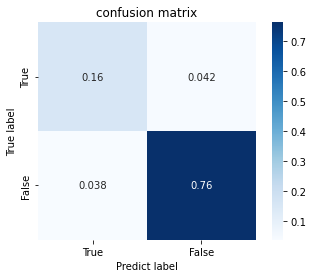

In [51]:
y_pred_lr = clf_lr.predict(X_test)
show_confusion_matrix(y_test, y_pred_lr)

# 決定木モデル
 
sklearnの決定木モデルを作成する。  
精度の高いモデルを選びたいので、葉の数を2~50まで変動させ、accuracyを見る

## 決定木モデルの構築・検証

決定木モデルを構築し、検証していく。  
パラメータを操作するため、forループで回し、最もスコアの高いものを見ていく。

In [52]:
import warnings

warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示

accuracies_tree = {}
precisions_tree = {}
recalls_tree = {}
f1_scores_tree = {}

for nodes_num in range(2, 50):
    clf_tree = DecisionTreeClassifier(max_leaf_nodes=nodes_num, random_state=SEED)
    clf_tree = clf_tree.fit(X_train, y_train)

    y_pred_tree = clf_tree.predict(X_test)

    accuracies_tree[nodes_num] = accuracy_score(y_test, y_pred_tree)
    precisions_tree[nodes_num] = precision_score(y_test, y_pred_tree)
    recalls_tree[nodes_num] = recall_score(y_test, y_pred_tree)
    f1_scores_tree[nodes_num] = f1_score(y_test, y_pred_tree)

    print("nodes_num: ", nodes_num)
    show_scores(y_test, y_pred_tree)
    print("----------" * 10)

warnings.filterwarnings("always")

nodes_num:  2
accuracy:  0.9169329073482428
precision:  0.7195121951219512
recall:  0.9516129032258065
f1 score:  0.8194444444444444
----------------------------------------------------------------------------------------------------
nodes_num:  3
accuracy:  0.9265175718849841
precision:  0.8
recall:  0.8387096774193549
f1 score:  0.8188976377952757
----------------------------------------------------------------------------------------------------
nodes_num:  4
accuracy:  0.9329073482428115
precision:  0.7808219178082192
recall:  0.9193548387096774
f1 score:  0.8444444444444444
----------------------------------------------------------------------------------------------------
nodes_num:  5
accuracy:  0.9329073482428115
precision:  0.7808219178082192
recall:  0.9193548387096774
f1 score:  0.8444444444444444
----------------------------------------------------------------------------------------------------
nodes_num:  6
accuracy:  0.9297124600638977
precision:  0.7857142857142857
reca

'max nodes_num'

4

14

2

4

accuracy:  0.9329073482428115
precision:  0.7808219178082192
recall:  0.9193548387096774
f1_score:  0.8444444444444444


Text(0, 0.5, 'score')

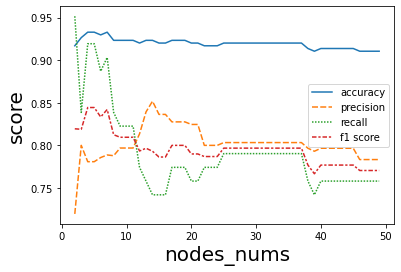

In [53]:
# 各スコアのプロット
display(
    "max nodes_num",
    max(accuracies_tree, key=accuracies_tree.get),
    max(precisions_tree, key=precisions_tree.get),
    max(recalls_tree, key=recalls_tree.get),
    max(f1_scores_tree, key=f1_scores_tree.get),
)

# f1_scoreが最も高いモデルのスコア
print(
    "accuracy: ",
    accuracies_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "precision: ",
    precisions_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "recall: ",
    recalls_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "f1_score: ",
    f1_scores_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)

df_score_tree = pd.DataFrame(
    [accuracies_tree, precisions_tree, recalls_tree, f1_scores_tree],
    index=["accuracy", "precision", "recall", "f1 score"],
    columns=accuracies_tree.keys(),
).T
p = sns.lineplot(data=df_score_tree)
p.set_xlabel("nodes_nums", fontsize=20)
p.set_ylabel("score", fontsize=20)

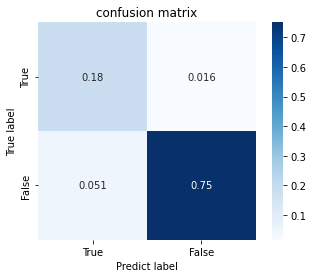

In [54]:
clf_tree = DecisionTreeClassifier(
    max_leaf_nodes=max(f1_scores_tree, key=f1_scores_tree.get),
    random_state=config.SEED,
)
clf_tree = clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)
show_confusion_matrix(y_test, y_pred_tree)

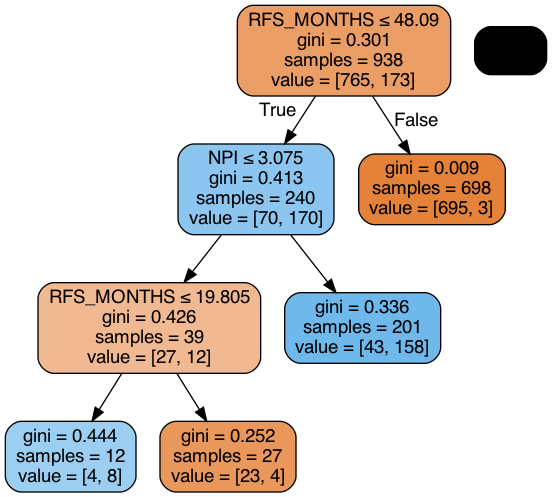

In [55]:
dot_data = StringIO()  # dotファイル情報の格納先
export_graphviz(
    clf_tree,
    out_file=dot_data,
    feature_names=X.columns,
    # class_names= y.unique(),
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
# graph.write_png(config.TREE_DIR + "/3.0.0-importance_dt.png")